# Data Cleaning & Preprocessing Pipeline

This notebook provides a modular, reproducible pipeline for cleaning and preprocessing sentiment analysis datasets. Each dataset is processed independently. Features:
- Standardized preprocessing across social media platforms
- Advanced text cleaning (emoji, contractions, social media features)
- Sentiment label standardization to (-1, 0, 1)
- Preprocessing impact analysis and visualization
- Configurable pipeline for different use cases
- Automated saving in training-ready format

## Table of Contents
1. Setup & Configuration
2. Preprocessing Pipeline
3. Airline Sentiment Dataset
4. Apple Twitter Sentiment Dataset
5. Reddit Sentiment Dataset
6. Twitter Social Sentiment Dataset
7. Twitter Combined Sentiment Dataset
8. Analysis & Validation
9. Export & Summary

## Setup & Configuration

In [19]:
# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from collections import Counter
import sys
import os

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Setup paths
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / 'data'
PREPROCESSED_DIR = DATA_DIR / 'preprocessed'
SRC_DIR = PROJECT_ROOT / 'src'

# Add src to path
sys.path.append(str(SRC_DIR))

# Import our advanced preprocessing modules
from preprocessing import CommentPreprocessor, VocabularyBuilder

# Setup NLTK
import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Create output directory
PREPROCESSED_DIR.mkdir(exist_ok=True)

print("Environment setup complete!")
print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {PREPROCESSED_DIR}")

Environment setup complete!
Data directory: c:\Users\tusik\Desktop\bak\Comment-Sentiment\data
Output directory: c:\Users\tusik\Desktop\bak\Comment-Sentiment\data\preprocessed


## 2. Preprocessing Pipeline

In [20]:
class PreprocessingPipeline:
    """
    Unified preprocessing pipeline for all sentiment datasets.
    """
    
    def __init__(self, config=None):
        """Initialize preprocessing pipeline with configuration."""
        # Default configuration optimized for sentiment analysis
        self.default_config = {
            'clean_text': True,
            'handle_mentions': True,
            'handle_hashtags': True,
            'handle_urls': True,
            'handle_emojis': 'convert',  # convert, remove, keep
            'expand_contractions': True,
            'correct_spelling': False,   # Too slow for large datasets
            'remove_stopwords': False,   # Important for sentiment
            'normalize_case': True
        }
        
        # Use provided config or default
        self.config = config or self.default_config
        self.preprocessor = CommentPreprocessor(config=self.config)
        
        # Dataset-specific configurations
        self.dataset_configs = {
            'airline': {
                'text_col': 'text',
                'label_col': 'airline_sentiment',
                'label_mapping': {'negative': -1, 'neutral': 0, 'positive': 1}
            },
            'apple': {
                'text_col': 'text', 
                'label_col': 'sentiment',
                'label_mapping': {'negative': -1, 'neutral': 0, 'positive': 1, '0': -1, '2': 0, '4': 1}
            },
            'reddit': {
                'text_col': 'clean_comment',
                'label_col': 'category', 
                'label_mapping': {'negative': -1, 'neutral': 0, 'positive': 1, '-1': -1, '0': 0, '1': 1}
            },
            'twitter_social': {
                'text_col': 'clean_text',
                'label_col': 'category',
                'label_mapping': {'negative': -1, 'neutral': 0, 'positive': 1, '-1': -1, '0': 0, '1': 1}
            },
            'twitter_combined': {
                'text_col': 'comment',
                'label_col': 'sentiment',
                'label_mapping': {'negative': -1, 'neutral': 0, 'positive': 1, '0': -1, '2': 0, '4': 1}
            }
        }
    
    def standardize_labels(self, labels, dataset_type):
        """Standardize sentiment labels to -1, 0, 1 format."""
        mapping = self.dataset_configs[dataset_type]['label_mapping']
        return [mapping.get(str(label).lower().strip(), 0) for label in labels]
    
    def process_dataset(self, df, dataset_type, dataset_name):
        """Process a complete dataset through the pipeline."""
        print(f"\n🔄 Processing {dataset_name} Dataset...")
        
        # Get dataset configuration
        config = self.dataset_configs[dataset_type]
        text_col = config['text_col']
        label_col = config['label_col']
        
        # Data cleaning steps
        original_count = len(df)
        print(f"📊 Original dataset size: {original_count:,} rows")
        
        # Remove duplicates
        df = df.drop_duplicates(subset=[text_col])
        print(f"🗑️  Removed {original_count - len(df):,} duplicate rows")
        
        # Handle missing values
        df = df.dropna(subset=[text_col, label_col])
        print(f"✅ Final dataset size: {len(df):,} rows")
        
        # Apply text preprocessing
        print("🧹 Applying text preprocessing...")
        df['clean_text'] = df[text_col].apply(self.preprocessor.preprocess_text)
        
        # Standardize sentiment labels
        print("🏷️  Standardizing sentiment labels...")
        df['sentiment_standardized'] = self.standardize_labels(df[label_col], dataset_type)
        
        # Print sentiment distribution
        self._print_sentiment_distribution(df['sentiment_standardized'], dataset_name)
        
        return df
    
    def _print_sentiment_distribution(self, labels, dataset_name):
        """Print sentiment distribution for a dataset."""
        counts = Counter(labels)
        total = len(labels)
        
        print(f"\n📈 {dataset_name} Sentiment Distribution:")
        print(f"   Negative (-1): {counts.get(-1, 0):,} ({counts.get(-1, 0)/total*100:.1f}%)")
        print(f"   Neutral (0):   {counts.get(0, 0):,} ({counts.get(0, 0)/total*100:.1f}%)")
        print(f"   Positive (1):  {counts.get(1, 0):,} ({counts.get(1, 0)/total*100:.1f}%)")
    
    def show_preprocessing_examples(self, df, dataset_name, n=3):
        """Show examples of preprocessing results."""
        print(f"\n💡 {dataset_name} Preprocessing Examples:")
        text_col = list(df.columns)[0] if 'text' in df.columns[0] else df.columns[0]
        
        for i in range(min(n, len(df))):
            original = str(df.iloc[i][text_col])[:80] + "..."
            cleaned = str(df.iloc[i]['clean_text'])[:80] + "..."
            sentiment = df.iloc[i]['sentiment_standardized']
            
            print(f"\n   Example {i+1}:")
            print(f"   Original:  {original}")
            print(f"   Cleaned:   {cleaned}")
            print(f"   Sentiment: {sentiment}")

# Initialize the preprocessing pipeline
pipeline = PreprocessingPipeline()

print("Preprocessing pipeline initialized!")
print("\nConfiguration:")
for key, value in pipeline.config.items():
    print(f"   {key}: {value}")

Preprocessing pipeline initialized!

Configuration:
   clean_text: True
   handle_mentions: True
   handle_hashtags: True
   handle_urls: True
   handle_emojis: convert
   expand_contractions: True
   correct_spelling: False
   remove_stopwords: False
   normalize_case: True


## 3. Airline Sentiment Dataset

In [22]:
# Load Airline Sentiment Dataset
airline_path = DATA_DIR / 'airline_sentiment' / 'Tweets.csv'
airline_df = pd.read_csv(airline_path)

# Process
airline_processed = pipeline.process_dataset(airline_df, 'airline', 'Airline Sentiment')
pipeline.show_preprocessing_examples(airline_processed, 'Airline Sentiment')

# Save
airline_out = airline_processed[['sentiment_standardized', 'clean_text']].copy()
airline_out.columns = ['sentiment', 'clean_text']
airline_out.to_csv(PREPROCESSED_DIR / 'airline_sentiment_cleaned.csv', index=False)
print(f"✅ Airline Sentiment dataset saved: {len(airline_out)} rows → {PREPROCESSED_DIR / 'airline_sentiment_cleaned.csv'}")


🔄 Processing Airline Sentiment Dataset...
📊 Original dataset size: 14,640 rows
🗑️  Removed 213 duplicate rows
✅ Final dataset size: 14,427 rows
🧹 Applying text preprocessing...
🏷️  Standardizing sentiment labels...

📈 Airline Sentiment Sentiment Distribution:
   Negative (-1): 9,080 (62.9%)
   Neutral (0):   3,057 (21.2%)
   Positive (1):  2,290 (15.9%)

💡 Airline Sentiment Preprocessing Examples:

   Example 1:
   Original:  570306133677760513...
   Cleaned:   <user> what <user> said....
   Sentiment: 0

   Example 2:
   Original:  570301130888122368...
   Cleaned:   <user> plus you have added commercials to the experience... tacky....
   Sentiment: 1

   Example 3:
   Original:  570301083672813571...
   Cleaned:   <user> i did not today... must mean i need to take another trip!...
   Sentiment: 0
✅ Airline Sentiment dataset saved: 14427 rows → c:\Users\tusik\Desktop\bak\Comment-Sentiment\data\preprocessed\airline_sentiment_cleaned.csv


## 4. Apple Twitter Sentiment Dataset

In [23]:
# Load Apple Twitter Sentiment Dataset
apple_path = DATA_DIR / 'apple_sentiment' / 'apple-twitter-sentiment-texts.csv'
apple_df = pd.read_csv(apple_path)

# Process
apple_processed = pipeline.process_dataset(apple_df, 'apple', 'Apple Twitter Sentiment')
pipeline.show_preprocessing_examples(apple_processed, 'Apple Twitter Sentiment')

# Save
apple_out = apple_processed[['sentiment_standardized', 'clean_text']].copy()
apple_out.columns = ['sentiment', 'clean_text']
apple_out.to_csv(PREPROCESSED_DIR / 'apple_sentiment_cleaned.csv', index=False)
print(f"✅ Apple Twitter Sentiment dataset saved: {len(apple_out)} rows → {PREPROCESSED_DIR / 'apple_sentiment_cleaned.csv'}")


🔄 Processing Apple Twitter Sentiment Dataset...
📊 Original dataset size: 1,630 rows
🗑️  Removed 6 duplicate rows
✅ Final dataset size: 1,624 rows
🧹 Applying text preprocessing...
🏷️  Standardizing sentiment labels...

📈 Apple Twitter Sentiment Sentiment Distribution:
   Negative (-1): 798 (49.1%)
   Neutral (0):   826 (50.9%)
   Positive (1):  0 (0.0%)

💡 Apple Twitter Sentiment Preprocessing Examples:

   Example 1:
   Original:  Wow. Yall needa step it up @Apple RT @heynyla: Music and snapchat at the same da...
   Cleaned:   wow. yall needa step it up <user> rt <user> music and snapchat at the same damn ...
   Sentiment: 0

   Example 2:
   Original:  What Happened To Apple Inc?   http://t.co/FJEXI3oP0U  #aapl #apple @MoneyPress h...
   Cleaned:   what happened to apple inc? http t.co fjexi3op0u aapl apple <user> http t.co wxk...
   Sentiment: -1

   Example 3:
   Original:  Thank u @apple I can now compile all of the pics that i communicate with in one ...
   Cleaned:   thank u <us

## 5. Reddit Sentiment Dataset

In [24]:
# Load Reddit Sentiment Dataset
reddit_path = DATA_DIR / 'social_media_sentiment' / 'Reddit_Data.csv'
reddit_df = pd.read_csv(reddit_path)

# Process
reddit_processed = pipeline.process_dataset(reddit_df, 'reddit', 'Reddit Sentiment')
pipeline.show_preprocessing_examples(reddit_processed, 'Reddit Sentiment')

# Save
reddit_out = reddit_processed[['sentiment_standardized', 'clean_text']].copy()
reddit_out.columns = ['sentiment', 'clean_text']
reddit_out.to_csv(PREPROCESSED_DIR / 'reddit_sentiment_cleaned.csv', index=False)
print(f"✅ Reddit Sentiment dataset saved: {len(reddit_out)} rows → {PREPROCESSED_DIR / 'reddit_sentiment_cleaned.csv'}")


🔄 Processing Reddit Sentiment Dataset...
📊 Original dataset size: 37,249 rows
🗑️  Removed 449 duplicate rows
✅ Final dataset size: 36,799 rows
🧹 Applying text preprocessing...
🏷️  Standardizing sentiment labels...

📈 Reddit Sentiment Sentiment Distribution:
   Negative (-1): 8,250 (22.4%)
   Neutral (0):   12,778 (34.7%)
   Positive (1):  15,771 (42.9%)

💡 Reddit Sentiment Preprocessing Examples:

   Example 1:
   Original:   family mormon have never tried explain them they still stare puzzled from time ...
   Cleaned:   family mormon have never tried explain them they still stare puzzled from time t...
   Sentiment: 1

   Example 2:
   Original:  buddhism has very much lot compatible with christianity especially considering t...
   Cleaned:   buddhism has very much lot compatible with christianity especially considering t...
   Sentiment: 1

   Example 3:
   Original:  seriously don say thing first all they won get its too complex explain normal pe...
   Cleaned:   seriously don say 

## 6. Twitter Social Sentiment Dataset

In [25]:
# Load Twitter Social Sentiment Dataset
twitter_social_path = DATA_DIR / 'social_media_sentiment' / 'Twitter_Data.csv'
twitter_social_df = pd.read_csv(twitter_social_path)

# Process
twitter_social_processed = pipeline.process_dataset(twitter_social_df, 'twitter_social', 'Twitter Social Sentiment')
pipeline.show_preprocessing_examples(twitter_social_processed, 'Twitter Social Sentiment')

# Save
twitter_social_out = twitter_social_processed[['sentiment_standardized', 'clean_text']].copy()
twitter_social_out.columns = ['sentiment', 'clean_text']
twitter_social_out.to_csv(PREPROCESSED_DIR / 'twitter_social_sentiment_cleaned.csv', index=False)
print(f"✅ Twitter Social Sentiment dataset saved: {len(twitter_social_out)} rows → {PREPROCESSED_DIR / 'twitter_social_sentiment_cleaned.csv'}")


🔄 Processing Twitter Social Sentiment Dataset...
📊 Original dataset size: 162,980 rows
🗑️  Removed 3 duplicate rows
✅ Final dataset size: 162,969 rows
🧹 Applying text preprocessing...
🏷️  Standardizing sentiment labels...

📈 Twitter Social Sentiment Sentiment Distribution:
   Negative (-1): 0 (0.0%)
   Neutral (0):   162,969 (100.0%)
   Positive (1):  0 (0.0%)

💡 Twitter Social Sentiment Preprocessing Examples:

   Example 1:
   Original:  when modi promised minimum government maximum governance expected him begin the ...
   Cleaned:   when modi promised minimum government maximum governance expected him begin the ...
   Sentiment: 0

   Example 2:
   Original:  talk all the nonsense and continue all the drama will vote for modi...
   Cleaned:   talk all the nonsense and continue all the drama will vote for modi...
   Sentiment: 0

   Example 3:
   Original:  what did just say vote for modi welcome bjp told you rahul the main campaigner f...
   Cleaned:   what did just say vote for mo

## 7. Twitter Combined Sentiment Dataset

In [26]:
# Load Twitter Combined Sentiment Dataset
twitter_combined_path = DATA_DIR / 'twitter_sentiment' / 'twitter_combined.csv'
twitter_combined_df = pd.read_csv(twitter_combined_path)

# Process
twitter_combined_processed = pipeline.process_dataset(twitter_combined_df, 'twitter_combined', 'Twitter Combined Sentiment')
pipeline.show_preprocessing_examples(twitter_combined_processed, 'Twitter Combined Sentiment')

# Save
twitter_combined_out = twitter_combined_processed[['sentiment_standardized', 'clean_text']].copy()
twitter_combined_out.columns = ['sentiment', 'clean_text']
twitter_combined_out.to_csv(PREPROCESSED_DIR / 'twitter_combined_sentiment_cleaned.csv', index=False)
print(f"✅ Twitter Combined Sentiment dataset saved: {len(twitter_combined_out)} rows → {PREPROCESSED_DIR / 'twitter_combined_sentiment_cleaned.csv'}")


🔄 Processing Twitter Combined Sentiment Dataset...
📊 Original dataset size: 75,682 rows
🗑️  Removed 5,707 duplicate rows
✅ Final dataset size: 69,974 rows
🧹 Applying text preprocessing...
🏷️  Standardizing sentiment labels...

📈 Twitter Combined Sentiment Sentiment Distribution:
   Negative (-1): 21,258 (30.4%)
   Neutral (0):   29,516 (42.2%)
   Positive (1):  19,200 (27.4%)

💡 Twitter Combined Sentiment Preprocessing Examples:

   Example 1:
   Original:  2401...
   Cleaned:   im getting on borderlands and i will murder you all ,...
   Sentiment: 1

   Example 2:
   Original:  2401...
   Cleaned:   i am coming to the borders and i will kill you all,...
   Sentiment: 1

   Example 3:
   Original:  2401...
   Cleaned:   im getting on borderlands and i will kill you all,...
   Sentiment: 1
✅ Twitter Combined Sentiment dataset saved: 69974 rows → c:\Users\tusik\Desktop\bak\Comment-Sentiment\data\preprocessed\twitter_combined_sentiment_cleaned.csv


## 8. Preprocessing Analysis & Validation

In [ ]:
def analyze_preprocessing_impact(original_df, processed_df, text_col, dataset_name):
    """Analyze the impact of preprocessing on text characteristics."""
    
    # Calculate text statistics
    original_lengths = original_df[text_col].astype(str).str.len()
    clean_lengths = processed_df['clean_text'].astype(str).str.len()
    
    original_words = original_df[text_col].astype(str).str.split().str.len()
    clean_words = processed_df['clean_text'].astype(str).str.split().str.len()
    
    # Calculate reductions
    char_reduction = ((original_lengths.mean() - clean_lengths.mean()) / original_lengths.mean() * 100)
    word_reduction = ((original_words.mean() - clean_words.mean()) / original_words.mean() * 100)
    
    return {
        'dataset': dataset_name,
        'original_char_avg': original_lengths.mean(),
        'clean_char_avg': clean_lengths.mean(),
        'char_reduction_pct': char_reduction,
        'original_word_avg': original_words.mean(), 
        'clean_word_avg': clean_words.mean(),
        'word_reduction_pct': word_reduction,
        'sample_count': len(processed_df)
    }

# Define processed_datasets mapping
processed_datasets = {
    'airline': airline_processed,
    'apple': apple_processed,
    'reddit': reddit_processed,
    'twitter_social': twitter_social_processed,
    'twitter_combined': twitter_combined_processed
}

# Define datasets_info for analysis
datasets_info = [
    {
        'type': 'airline',
        'name': 'Airline Sentiment',
        'file_path': str(DATA_DIR / 'airline_sentiment' / 'Tweets.csv')
    },
    {
        'type': 'apple',
        'name': 'Apple Twitter Sentiment',
        'file_path': str(DATA_DIR / 'apple_sentiment' / 'apple-twitter-sentiment-texts.csv')
    },
    {
        'type': 'reddit',
        'name': 'Reddit Sentiment',
        'file_path': str(DATA_DIR / 'social_media_sentiment' / 'Reddit_Data.csv')
    },
    {
        'type': 'twitter_social',
        'name': 'Twitter Social Sentiment',
        'file_path': str(DATA_DIR / 'social_media_sentiment' / 'Twitter_Data.csv')
    },
    {
        'type': 'twitter_combined',
        'name': 'Twitter Combined Sentiment',
        'file_path': str(DATA_DIR / 'twitter_sentiment' / 'twitter_combined.csv')
    }
]

# Analyze all processed datasets
analysis_results = []

print("📊 Analyzing preprocessing impact across datasets...\n")

for dataset_type, processed_df in processed_datasets.items():
    # Find corresponding original dataset info
    dataset_info = next(d for d in datasets_info if d['type'] == dataset_type)
    
    # Load original for comparison
    try:
        original_df = pd.read_csv(dataset_info['file_path'])
        text_col = pipeline.dataset_configs[dataset_type]['text_col']
        
        # Analyze impact
        analysis = analyze_preprocessing_impact(
            original_df, processed_df, text_col, dataset_info['name']
        )
        analysis_results.append(analysis)
        
        print(f"📋 {dataset_info['name']}:")
        print(f"   📏 Avg character length: {analysis['original_char_avg']:.1f} → {analysis['clean_char_avg']:.1f} (-{analysis['char_reduction_pct']:.1f}%)")
        print(f"   📝 Avg word count: {analysis['original_word_avg']:.1f} → {analysis['clean_word_avg']:.1f} (-{analysis['word_reduction_pct']:.1f}%)")
        print(f"   📊 Sample count: {analysis['sample_count']:,}")
        print()
        
    except Exception as e:
        print(f"❌ Could not analyze {dataset_info['name']}: {str(e)}")

📊 Analyzing preprocessing impact across datasets...

📋 Airline Sentiment:
   📏 Avg character length: 103.8 → 99.1 (-4.5%)
   📝 Avg word count: 17.7 → 18.3 (--3.5%)
   📊 Sample count: 14,427

📋 Apple Twitter Sentiment:
   📏 Avg character length: 95.3 → 90.6 (-5.0%)
   📝 Avg word count: 14.5 → 16.0 (--10.0%)
   📊 Sample count: 1,624

📋 Reddit Sentiment:
   📏 Avg character length: 180.9 → 181.4 (--0.3%)
   📝 Avg word count: 29.3 → 29.6 (--0.8%)
   📊 Sample count: 36,799

📋 Twitter Social Sentiment:
   📏 Avg character length: 124.2 → 123.3 (-0.7%)
   📝 Avg word count: 20.1 → 20.0 (-0.4%)
   📊 Sample count: 162,969

📋 Twitter Combined Sentiment:
   📏 Avg character length: 108.1 → 110.8 (--2.5%)
   📝 Avg word count: 19.1 → 20.2 (--5.9%)
   📊 Sample count: 69,974



In [35]:
# Create analysis summary DataFrame
analysis_df = pd.DataFrame(analysis_results)
print("📈 Preprocessing Impact Summary:")
analysis_df

📈 Preprocessing Impact Summary:


,dataset,original_char_avg,clean_char_avg,char_reduction_pct,original_word_avg,clean_word_avg,word_reduction_pct,sample_count
0,Airline Sentiment,103.822063,99.148125,4.501873,17.653415,18.278228,-3.539332,14427
1,Apple Twitter Sentiment,95.341718,90.582512,4.991735,14.520245,15.966133,-9.957735,1624
2,Reddit Sentiment,180.909796,181.434985,-0.290304,29.327579,29.550423,-0.759842,36799
3,Twitter Social Sentiment,124.173518,123.267689,0.729487,20.079948,20.009315,0.351763,162969
4,Twitter Combined Sentiment,108.129568,110.844114,-2.510456,19.084049,20.219253,-5.948443,69974


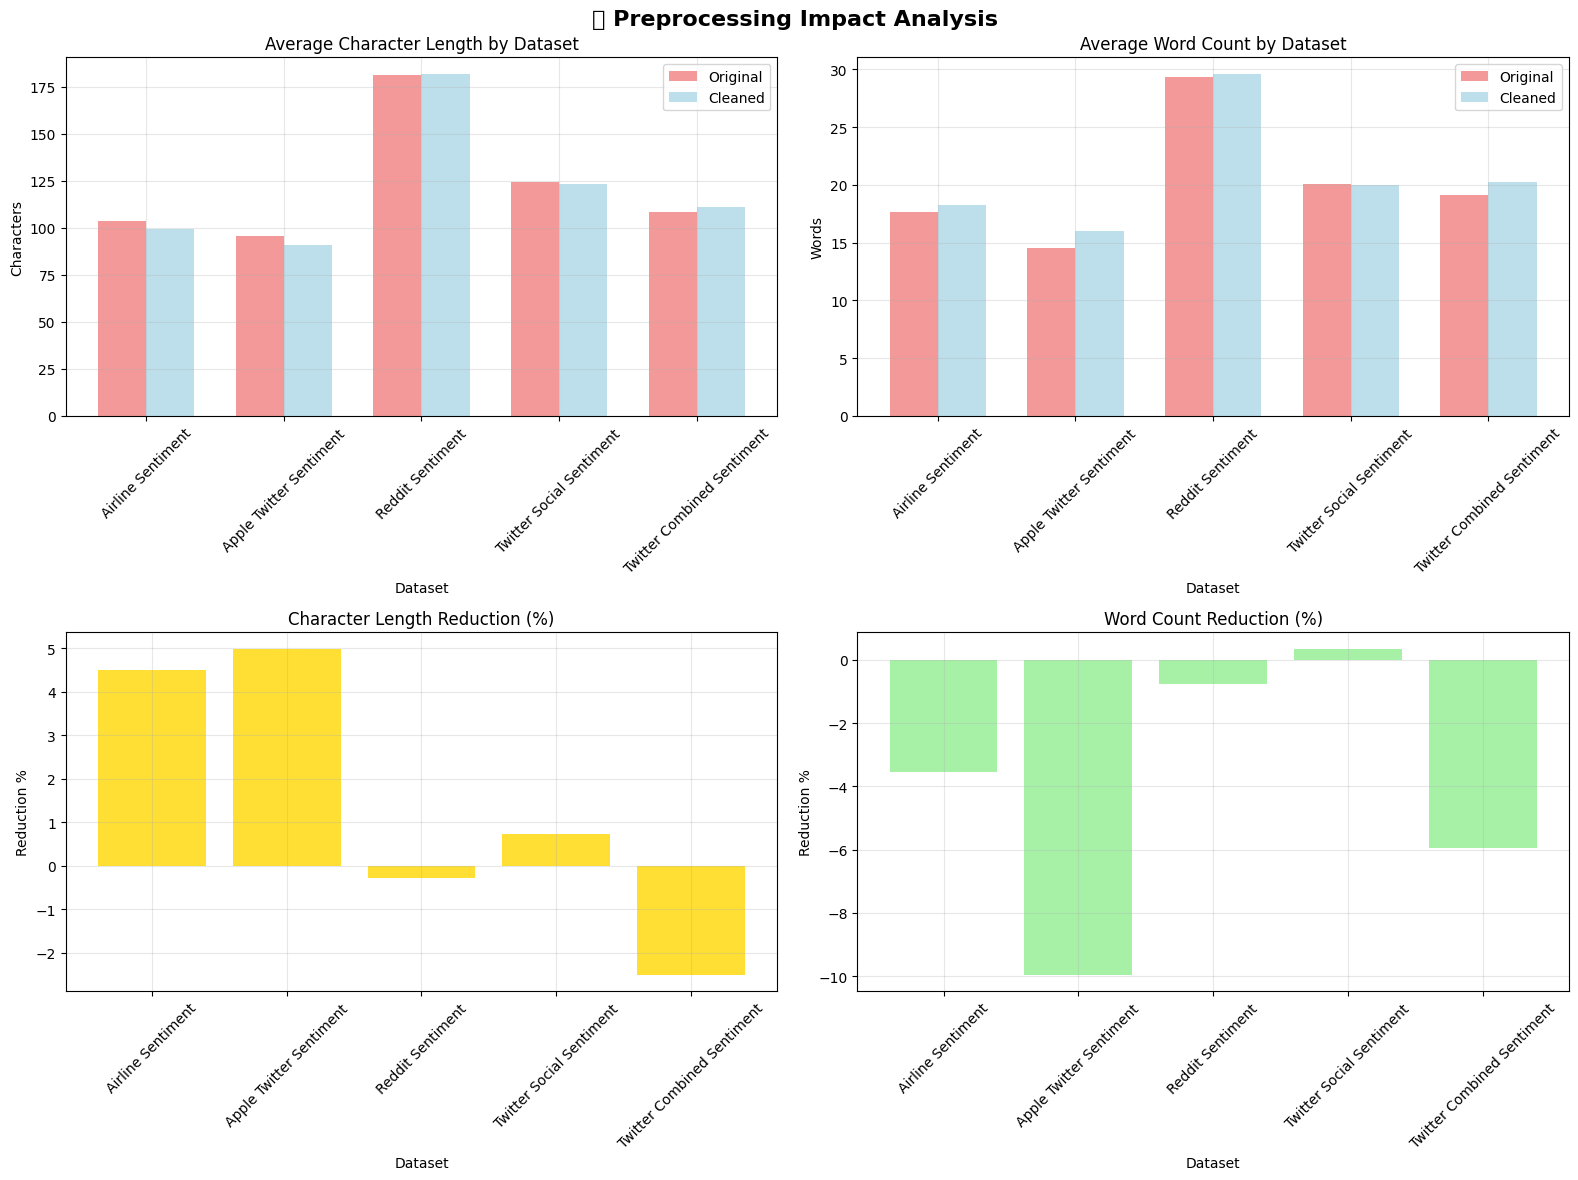

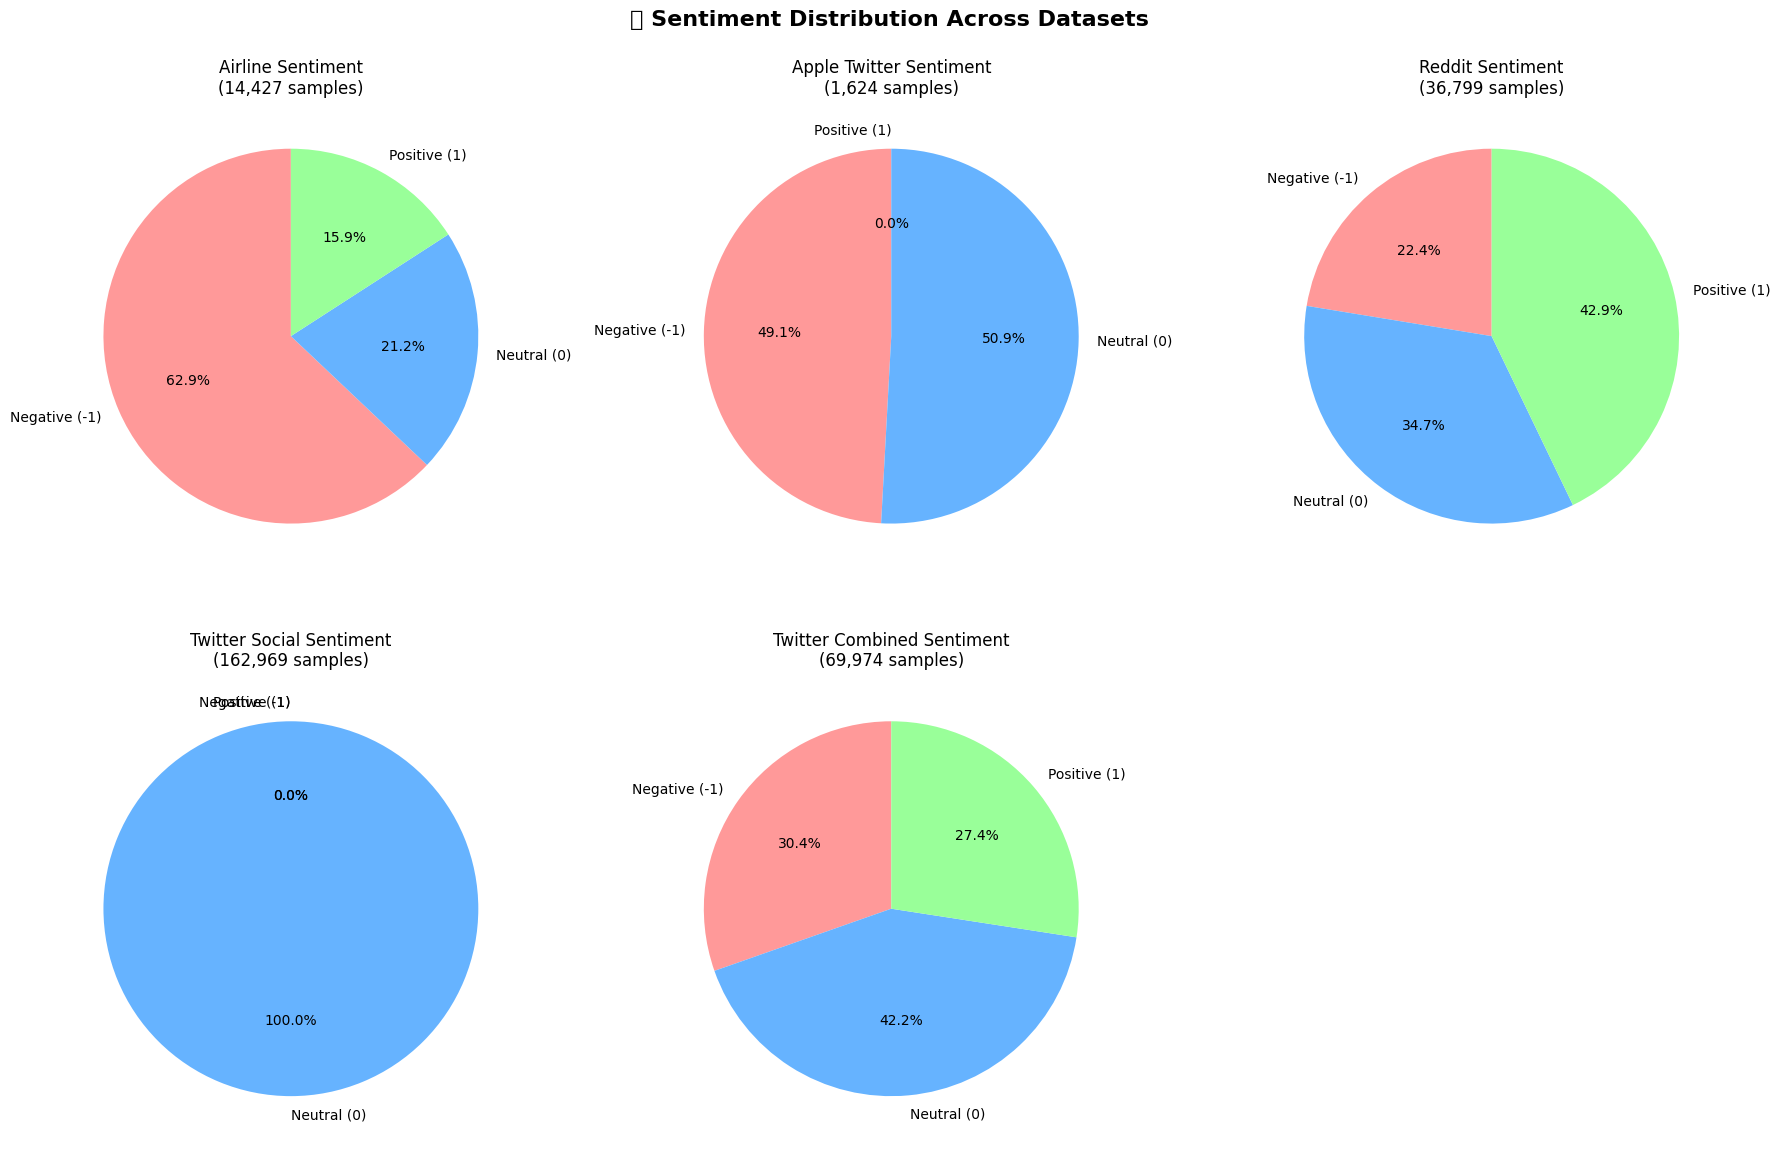

📊 Analysis complete!


In [30]:
# Create comprehensive visualization
if analysis_results:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('📊 Preprocessing Impact Analysis', fontsize=16, fontweight='bold')
    
    # Character length comparison
    datasets = [r['dataset'] for r in analysis_results]
    original_chars = [r['original_char_avg'] for r in analysis_results]
    clean_chars = [r['clean_char_avg'] for r in analysis_results]
    
    x = np.arange(len(datasets))
    width = 0.35
    
    axes[0,0].bar(x - width/2, original_chars, width, label='Original', alpha=0.8, color='lightcoral')
    axes[0,0].bar(x + width/2, clean_chars, width, label='Cleaned', alpha=0.8, color='lightblue')
    axes[0,0].set_title('Average Character Length by Dataset')
    axes[0,0].set_ylabel('Characters')
    axes[0,0].set_xlabel('Dataset')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels(datasets, rotation=45)
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Word count comparison
    original_words = [r['original_word_avg'] for r in analysis_results]
    clean_words = [r['clean_word_avg'] for r in analysis_results]
    
    axes[0,1].bar(x - width/2, original_words, width, label='Original', alpha=0.8, color='lightcoral')
    axes[0,1].bar(x + width/2, clean_words, width, label='Cleaned', alpha=0.8, color='lightblue')
    axes[0,1].set_title('Average Word Count by Dataset')
    axes[0,1].set_ylabel('Words')
    axes[0,1].set_xlabel('Dataset')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels(datasets, rotation=45)
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Reduction percentages
    char_reductions = [r['char_reduction_pct'] for r in analysis_results]
    word_reductions = [r['word_reduction_pct'] for r in analysis_results]
    
    axes[1,0].bar(datasets, char_reductions, alpha=0.8, color='gold')
    axes[1,0].set_title('Character Length Reduction (%)')
    axes[1,0].set_ylabel('Reduction %')
    axes[1,0].set_xlabel('Dataset')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].grid(True, alpha=0.3)
    
    axes[1,1].bar(datasets, word_reductions, alpha=0.8, color='lightgreen')
    axes[1,1].set_title('Word Count Reduction (%)')
    axes[1,1].set_ylabel('Reduction %')
    axes[1,1].set_xlabel('Dataset')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Sentiment distribution pie chart
    if processed_datasets:
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('🎯 Sentiment Distribution Across Datasets', fontsize=16, fontweight='bold')
        axes = axes.flatten()
        
        for i, (dataset_type, df) in enumerate(processed_datasets.items()):
            if i < len(axes):
                sentiment_counts = Counter(df['sentiment_standardized'])
                labels = ['Negative (-1)', 'Neutral (0)', 'Positive (1)']
                sizes = [sentiment_counts.get(-1, 0), sentiment_counts.get(0, 0), sentiment_counts.get(1, 0)]
                colors = ['#ff9999', '#66b3ff', '#99ff99']
                
                dataset_name = next(d['name'] for d in datasets_info if d['type'] == dataset_type)
                axes[i].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
                axes[i].set_title(f'{dataset_name}\n({sum(sizes):,} samples)')
        
        # Hide unused subplots
        for i in range(len(processed_datasets), len(axes)):
            axes[i].set_visible(False)
            
        plt.tight_layout()
        plt.show()

print("📊 Analysis complete!")

## 9. Advanced Preprocessing Features Demonstration

Demonstrate specific preprocessing capabilities with examples.

In [31]:
# Demonstrate different preprocessing configurations
print("=== Advanced Preprocessing Features Demo ===")

# Test various preprocessing configurations
configs = {
    'Conservative': {
        'clean_text': True,
        'handle_mentions': False,
        'handle_hashtags': False, 
        'handle_urls': True,
        'handle_emojis': 'keep',
        'expand_contractions': False,
        'remove_stopwords': False,
        'normalize_case': False
    },
    'Aggressive': {
        'clean_text': True,
        'handle_mentions': True,
        'handle_hashtags': True,
        'handle_urls': True, 
        'handle_emojis': 'remove',
        'expand_contractions': True,
        'remove_stopwords': True,
        'normalize_case': True
    },
    'Social Media Optimized': {
        'clean_text': True,
        'handle_mentions': True,
        'handle_hashtags': True,
        'handle_urls': True,
        'handle_emojis': 'convert',
        'expand_contractions': True,
        'remove_stopwords': False,
        'normalize_case': True
    }
}

# Sample text for demonstration
sample_text = "@user This is AMAZING! 😀 Check out https://example.com #awesome Don't you think it's great? LOL 🎉"

print(f"Original text: {sample_text}\n")

for config_name, config in configs.items():
    preprocessor_demo = CommentPreprocessor(config=config)
    processed = preprocessor_demo.preprocess_text(sample_text)
    print(f"{config_name:20}: {processed}")

print("\n" + "="*60)
print("Feature-by-feature demonstration:")
print("="*60)

# Demonstrate individual features
base_preprocessor = CommentPreprocessor(config={'clean_text': False})

features = [
    ('Original', sample_text),
    ('URL Handling', base_preprocessor.handle_urls(sample_text)),
    ('Mention Handling', base_preprocessor.handle_mentions(sample_text)),
    ('Hashtag Handling', base_preprocessor.handle_hashtags(sample_text)),
    ('Emoji Convert', base_preprocessor.handle_emojis(sample_text)),
    ('Contraction Expansion', base_preprocessor.expand_contractions(sample_text)),
    ('Case Normalization', base_preprocessor.normalize_case(sample_text))
]

for feature_name, result in features:
    print(f"{feature_name:20}: {result}")

=== Advanced Preprocessing Features Demo ===
Original text: @user This is AMAZING! 😀 Check out https://example.com #awesome Don't you think it's great? LOL 🎉

Conservative        : @user This is AMAZING! Check out https: example.com #awesome Don't you think it's great? LOL
Aggressive          : < user > amazing ! check https : example.com awesome think great ? lol
Social Media Optimized: <user> this is amazing! check out https example.com awesome do not you think it is great? lol

Feature-by-feature demonstration:
Original            : @user This is AMAZING! 😀 Check out https://example.com #awesome Don't you think it's great? LOL 🎉
URL Handling        : @user This is AMAZING! 😀 Check out  <URL>  #awesome Don't you think it's great? LOL 🎉
Mention Handling    :  <USER>  This is AMAZING! 😀 Check out https://example.com #awesome Don't you think it's great? LOL 🎉
Hashtag Handling    : @user This is AMAZING! 😀 Check out https://example.com  awesome  Don't you think it's great? LOL 🎉
Emoji Co

In [32]:
# Final summary
print("\n" + "="*60)
print("PREPROCESSING COMPLETE - SUMMARY")
print("="*60)
print("\nDatasets processed:")
print(f"  • Airline Sentiment: {len(airline_df):,} samples")
print(f"  • Apple Sentiment: {len(apple_df):,} samples")
print(f"  • Reddit Sentiment: {len(reddit_df):,} samples")
print(f"  • Twitter Social: {len(twitter_social_df):,} samples")
print(f"  • Twitter Combined: {len(twitter_combined_df):,} samples")

total_samples = len(airline_df) + len(apple_df) + len(reddit_df) + len(twitter_social_df) + len(twitter_combined_df)
print(f"\nTotal samples processed: {total_samples:,}")

print("\nPreprocessed datasets saved to: ../data/preprocessed/")


PREPROCESSING COMPLETE - SUMMARY

Datasets processed:
  • Airline Sentiment: 14,640 samples
  • Apple Sentiment: 1,630 samples
  • Reddit Sentiment: 37,249 samples
  • Twitter Social: 162,980 samples
  • Twitter Combined: 75,682 samples

Total samples processed: 292,181

Preprocessed datasets saved to: ../data/preprocessed/
